In [1]:
import datetime
import requests
import ccxt
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from dataset import Dataset
from binance_utils import get_all_coins, get_all_symbols
from binance import Client
from dotenv import dotenv_values
from scipy.optimize import curve_fit

In [23]:
def top_crypto(n=100):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": n,
        "page": 1,
        "sparkline": False,
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        return data
    except requests.exceptions.HTTPError as e:
        print("Error retrieving data:", e)
        return None

In [24]:
coins = top_crypto(500)

In [25]:
len(coins)

250

In [26]:
config = dotenv_values('.env')
binance_client = Client(config.get('BINANCE_API_KEY'), config.get('BINANCE_API_SECRET'))

# Correlations

In [27]:
coins = [coin['symbol'].upper() for coin in top_crypto(500)]

In [28]:
binance_coins = get_all_coins()
binance_coins.sort()
print(len(binance_coins))

547


In [29]:
binance_symbols = get_all_symbols()
binance_symbols.sort()
print(len(binance_symbols))

2823


In [30]:
tickers = [c + 'USDT' for c in coins if c + 'USDT' in binance_symbols]
len(tickers)

157

In [31]:
ds = Dataset()

In [32]:
klines = ds.get_data(tickers[0], '4h', start_date='2024-1-1')

In [33]:
klines

,open,high,low,close,volume,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume
time,,,,,,,,,
2024-01-01 04:00:00,42283.58,42775.00,42230.08,42330.49,3948.083350,1.678186e+08,166013.0,2040.258810,8.672708e+07
2024-01-01 08:00:00,42330.50,42500.00,42180.77,42492.46,2706.998800,1.146432e+08,128552.0,1385.792720,5.868746e+07
2024-01-01 12:00:00,42492.46,42762.39,42452.58,42690.20,2948.802740,1.257459e+08,137484.0,1523.256950,6.495947e+07
2024-01-01 16:00:00,42690.21,42847.07,42580.00,42783.05,2936.444060,1.253587e+08,148756.0,1496.350930,6.387751e+07
2024-01-01 20:00:00,42783.05,43550.00,42664.42,43517.99,5686.971640,2.449706e+08,242235.0,3016.449080,1.299520e+08
...,...,...,...,...,...,...,...,...,...
2024-12-04 20:00:00,95742.80,97232.01,94587.83,97209.64,9467.011220,9.053128e+08,1536757.0,4847.196970,4.637899e+08
2024-12-05 00:00:00,97209.64,99000.00,97128.52,98587.32,14248.478860,1.401596e+09,1537798.0,7595.198840,7.471383e+08
2024-12-05 04:00:00,98587.32,104088.00,97888.89,102964.00,29911.489432,3.023164e+09,2782204.0,16369.464976,1.652779e+09


<AxesSubplot:xlabel='time'>

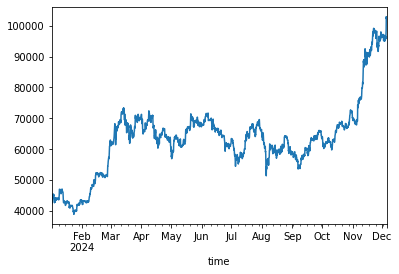

In [34]:
klines['close'].plot()

In [12]:
data = {}
for ticker in tickers:
    data[ticker] = ds.get_data(ticker, '4h', start_date='2024-1-1')['close']

KeyboardInterrupt: 

In [ ]:
cts = []
for dt in data.values():
    cts.append(dt.shape[0])
cts.sort()
cts

In [13]:
data_full = {key:val for key, val in data.items() if val.shape[0] == max(cts)}
data_full = pd.DataFrame.from_dict(data_full)

In [14]:
(data_full.std() / data_full.mean()).sort_values().head(10)

USDCUSDT     0.000623
FDUSDUSDT    0.001945
TUSDUSDT     0.010467
PAXGUSDT     0.063530
ELFUSDT      0.070962
SFPUSDT      0.074919
XRPUSDT      0.085249
TRXUSDT      0.092539
XLMUSDT      0.093164
QNTUSDT      0.096719
dtype: float64

In [15]:
data_full = data_full.drop(columns=['USDCUSDT', 'FDUSDUSDT', 'TUSDUSDT', 'PAXGUSDT'])

In [16]:
corr = data_full.corr()

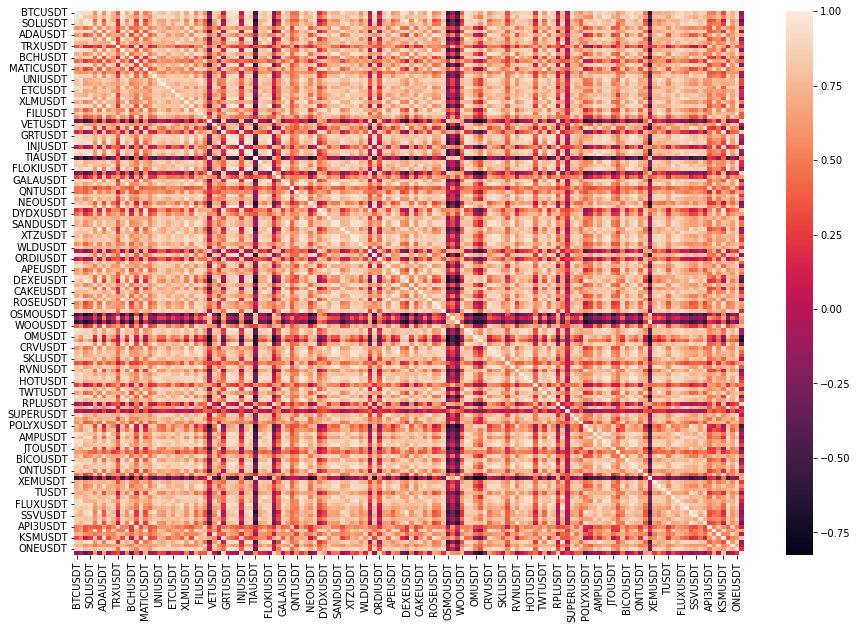

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax = sns.heatmap(corr)
plt.show()

In [18]:
corr['BTCUSDT'].sort_values(ascending=True).head(10)

FXSUSDT    -0.601134
ASTRUSDT   -0.600839
OSMOUSDT   -0.558132
TIAUSDT    -0.554105
ARBUSDT    -0.371759
LDOUSDT    -0.274085
GMXUSDT    -0.183703
BLURUSDT   -0.130507
SCUSDT     -0.070921
MINAUSDT   -0.064837
Name: BTCUSDT, dtype: float64

In [19]:
corr['BTCUSDT'].sort_values(ascending=False).head(10)

BTCUSDT      1.000000
WBTCUSDT     0.999975
NEXOUSDT     0.970341
AGIXUSDT     0.964890
OCEANUSDT    0.963294
ARUSDT       0.959476
FETUSDT      0.959249
JASMYUSDT    0.954974
THETAUSDT    0.954510
ETHUSDT      0.949330
Name: BTCUSDT, dtype: float64

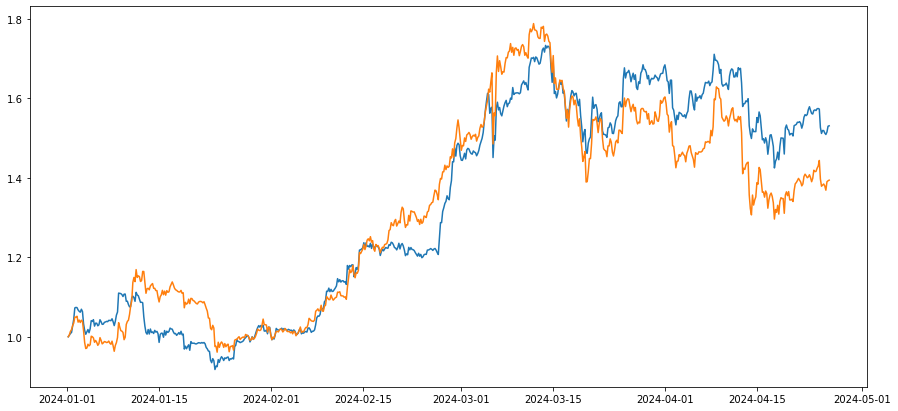

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(data['BTCUSDT'] / data['BTCUSDT'].iloc[0])
plt.plot(data['ETHUSDT'] / data['ETHUSDT'].iloc[0])
plt.show()

# BTC

In [2]:
datetime.datetime.now()

datetime.datetime(2024, 12, 5, 10, 35, 52, 198120)

In [3]:
bitstamp = ccxt.bitstamp()

timeframe = '1d'

start_date = pd.Timestamp('2011-08-18')
end_date = datetime.datetime.now()

btc = pd.DataFrame()

while True:
    ohlcv = bitstamp.fetch_ohlcv('BTC/USD', timeframe, limit=1000, since=int(start_date.timestamp() * 1000))
    
    if len(ohlcv) == 0:
        break
    
    chunk_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    chunk_df['timestamp'] = pd.to_datetime(chunk_df['timestamp'], unit='ms')
    chunk_df = chunk_df.set_index('timestamp', drop=True)
    chunk_df = chunk_df[chunk_df.index <= end_date]
    btc = pd.concat([btc, chunk_df])
    
    if chunk_df.index[-1] == end_date:
        break
    
    start_date = chunk_df.index[-1] + pd.Timedelta(days=1)

In [4]:
btc

,open,high,low,close,volume
timestamp,,,,,
2011-08-18,10.90,10.90,10.90,10.90,0.489908
2011-08-19,11.85,11.85,11.15,11.69,1.926578
2011-08-20,11.70,11.70,11.70,11.70,0.085470
2011-08-21,11.70,11.70,11.70,11.70,0.085470
2011-08-22,11.70,11.70,11.70,11.70,0.028632
...,...,...,...,...,...
2024-12-01,96471.00,97880.00,95758.00,97291.00,884.655660
2024-12-02,97260.00,98200.00,94403.00,95859.00,3225.021016
2024-12-03,95858.00,96301.00,93590.00,95926.00,3484.909125


## EMA distance

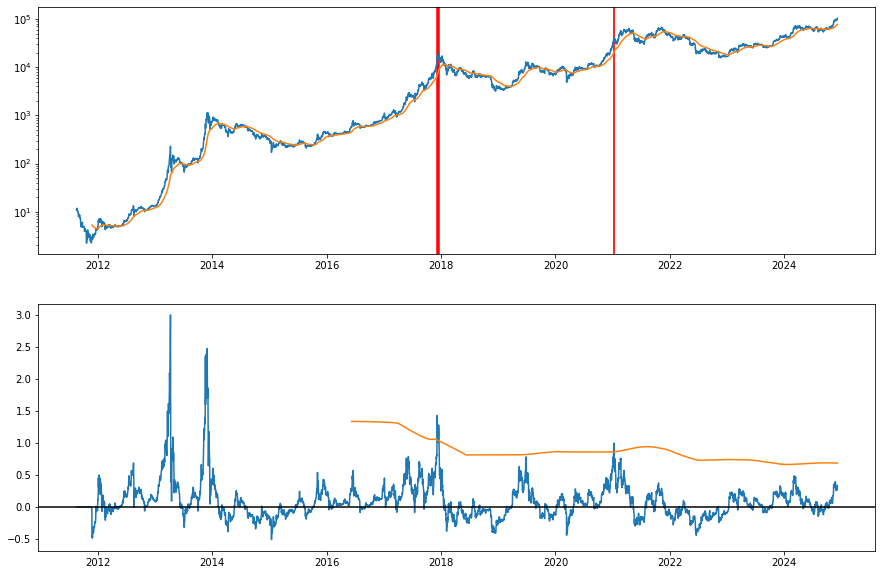

In [5]:
ma_len = 100
diff = (btc['close'] - btc.ta.ema(ma_len)) / btc.ta.ema(ma_len)
# thr = diff.mean() + 3 * diff.std()
# thr = diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()
thr = (diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()).rolling(200).mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(btc[diff > thr].shape[0]):
    ax[0].axvline(btc[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(btc['close'])
ax[0].plot(btc.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
plt.plot(thr)
ax[1].axhline(0, c='k')
plt.show()

### Risk

In [6]:
risk_ma = pd.Series(data=0, index=btc.index)
thrs = []
for ma_len in range(10, 201, 1):
    diff = (btc['close'] - btc.ta.ema(ma_len)) / btc.ta.ema(ma_len)
    thrs.append((diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()).rolling(200).mean())
    risk_ma += diff

In [7]:
thr = pd.concat(thrs, axis=1).dropna().mean(axis=1)

In [8]:
risk_ma = risk_ma / thr
risk_ma = (risk_ma - risk_ma.min()) / (risk_ma.max() - risk_ma.min())

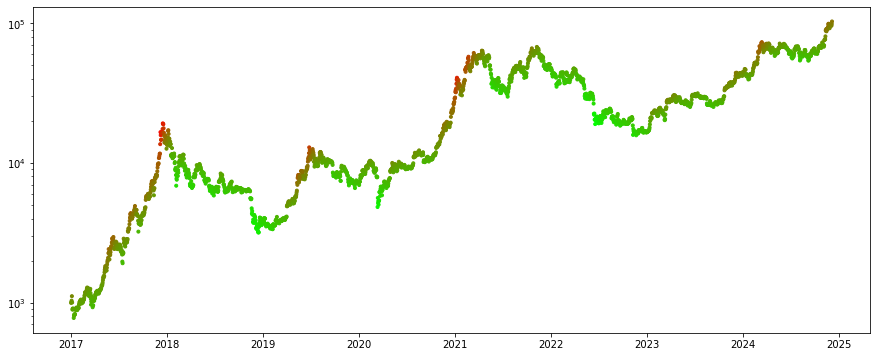

In [9]:
colors = [(0, 1, 0), (1, 0, 0)]
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc.loc['2017-1-1':].index, btc['close'].loc['2017-1-1':], marker='.',
            c=risk_ma.loc['2017-1-1':], cmap=cmap)
plt.yscale('log')
plt.show()

### Alarm

In [10]:
alarm = pd.Series(data=0, index=btc.index)

In [11]:
for ma_len in range(10, 201, 1):
    diff = (btc['close'] - btc.ta.ema(ma_len)) / btc.ta.ema(ma_len)
    thr = (diff.rolling(4*365).mean() + 3 * diff.rolling(4*365).std()).rolling(200).mean()
    alarm.loc[diff >= thr] += 1

In [12]:
alarm_n = alarm / alarm.max()

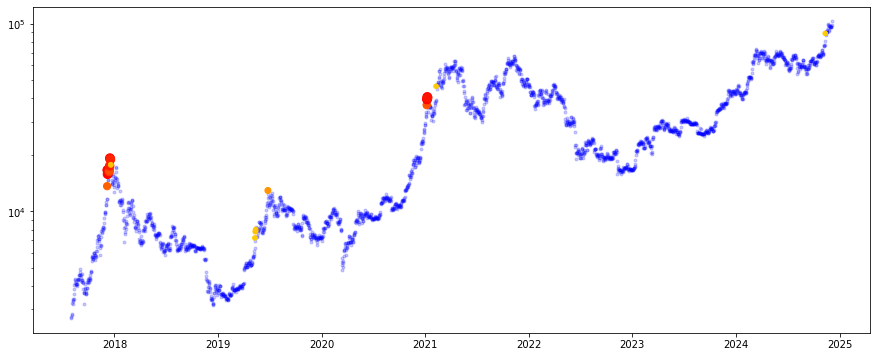

In [13]:
colors = [(1, 0.8, 0), (1, 0, 0)] # orange to red
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc[alarm_n==0].loc['2017-8-1':].index, btc[alarm_n==0]['close'].loc['2017-8-1':],
            marker='.', c='b', alpha=0.2)
plt.scatter(btc[alarm_n>0].loc['2017-8-1':].index, btc[alarm_n>0]['close'].loc['2017-8-1':],
            marker='o', c=alarm_n[alarm_n>0].loc['2017-8-1':], cmap=cmap,
            s=20 * (1 + 3 * alarm_n[alarm_n>0].loc['2017-8-1':]))
plt.yscale('log')
plt.show()

## Pi Cycle Top

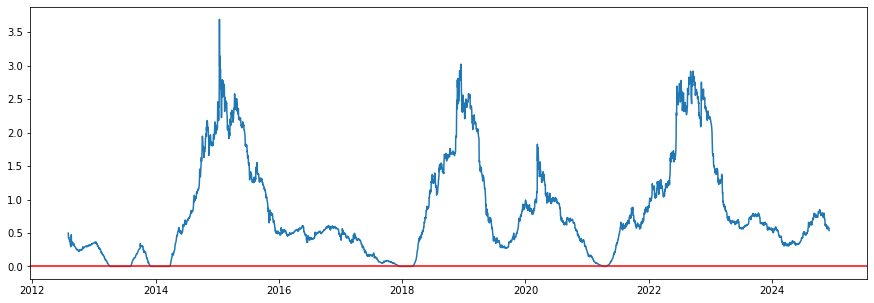

In [14]:
ma_diff = (btc.ta.sma(350) * 2 - btc.ta.sma(111)) / btc['close']
ma_diff[ma_diff < 0] = 0

plt.figure(figsize=(15, 5))
plt.plot(ma_diff)
plt.axhline(0, c='r')
plt.show()

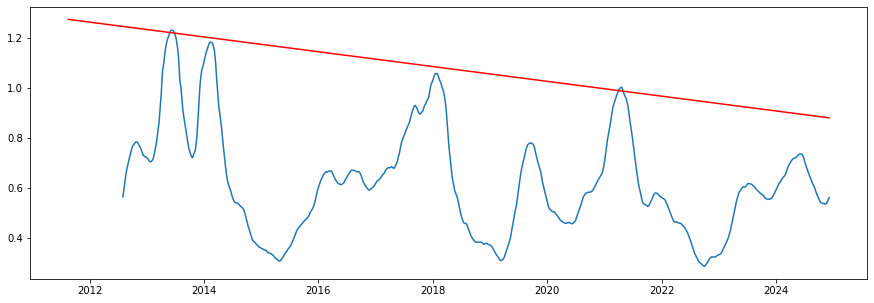

In [15]:
pi_ratio = (btc.ta.sma(111) / (btc.ta.sma(350) * 2))

x1 = np.where(pi_ratio.to_numpy()==pi_ratio.loc['2013-1-1':'2014-1-1'].to_numpy().max())[0][0]
y1 = pi_ratio.loc['2013-1-1':'2014-1-1'].to_numpy().max()
x2 = np.where(pi_ratio.to_numpy()==pi_ratio.loc['2015-1-1':'2019-1-1'].to_numpy().max())[0][0]
y2 = pi_ratio.loc['2015-1-1':'2019-1-1'].to_numpy().max()
x3 = np.where(pi_ratio.to_numpy()==pi_ratio.loc['2019-1-1':'2022-1-1'].to_numpy().max())[0][0]
y3 = pi_ratio.loc['2019-1-1':'2022-1-1'].to_numpy().max()

x_data = np.array([x1, x2, x3])
y_data = np.array([y1, y2, y3])

def linear_func(x, m, c):
    return m * x + c

params, covariance = curve_fit(linear_func, x_data, y_data)
m, c = params

x_fit = range(pi_ratio.shape[0])
y_fit = linear_func(x_fit, m, c)
y_fit = pd.Series(data = y_fit, index=pi_ratio.index)

plt.figure(figsize=(15, 5))
plt.plot(pi_ratio)
plt.plot(y_fit, c='r')
plt.show()

### Alarm

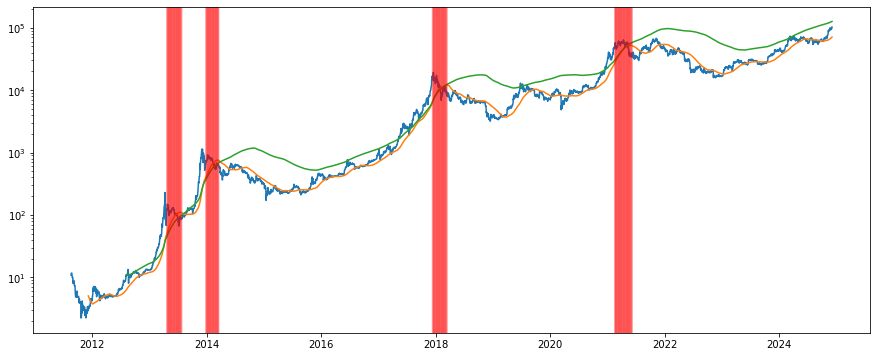

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(btc['close'])
plt.plot(btc.ta.sma(111))
plt.plot(btc.ta.sma(350) * 2)
# for idx in ma_diff[ma_diff == 0].index:
#     plt.axvline(idx, c='r', alpha=0.1)
for idx in pi_ratio[pi_ratio >= 0.9 * y_fit].index:
    plt.axvline(idx, c='r', alpha=0.1)
plt.yscale('log')
plt.show()

### Risk

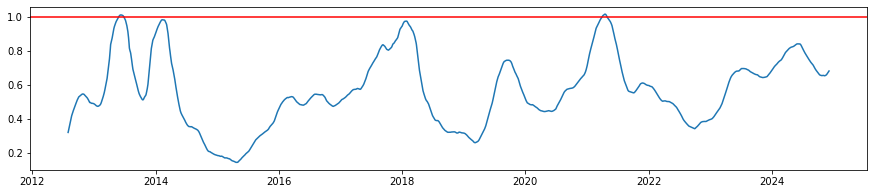

In [17]:
# risk_pi = ma_diff / ma_diff.max()
# risk_pi = 1 - risk_pi
# risk_pi **= 10
risk_pi = 1 - (y_fit - pi_ratio)

plt.figure(figsize=(15, 3))
plt.plot(risk_pi)
plt.axhline(1, c='r')
plt.show()

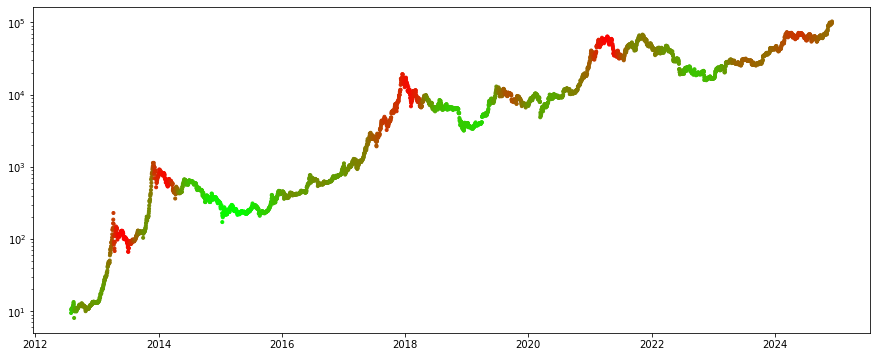

In [18]:
colors = [(0, 1, 0), (1, 0, 0)]
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc.index, btc['close'], marker='.', c=risk_pi, cmap=cmap)
plt.yscale('log')
plt.show()

## Cumulative risk

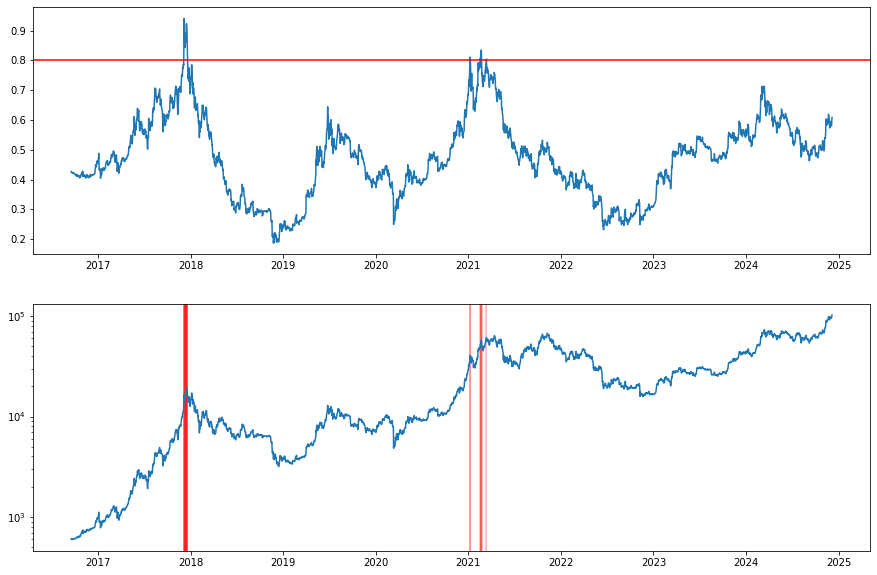

In [19]:
risk_cum = (risk_ma + risk_pi) / 2

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(risk_cum.dropna())
ax[0].axhline(0.8, c='r')
for idx in risk_cum[risk_cum >= 0.8].index:
    ax[1].axvline(idx, c='r', alpha=0.3)
ax[1].plot(btc['close'].loc[risk_cum.dropna().index])
ax[1].set_yscale('log')
plt.show()

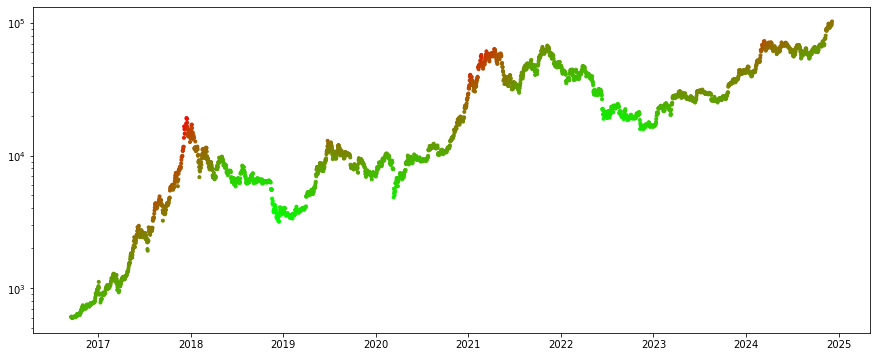

In [20]:
colors = [(0, 1, 0), (1, 0, 0)]
positions = [0, 1]  # Corresponding to low and high values
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

plt.figure(figsize=(15, 6))
plt.scatter(btc.index, btc['close'], marker='.', c=risk_cum, cmap=cmap)
plt.yscale('log')
plt.show()

# SOL

In [35]:
sol = ds.get_data('SOLUSDT', '1d', start_date='2020-1-1')

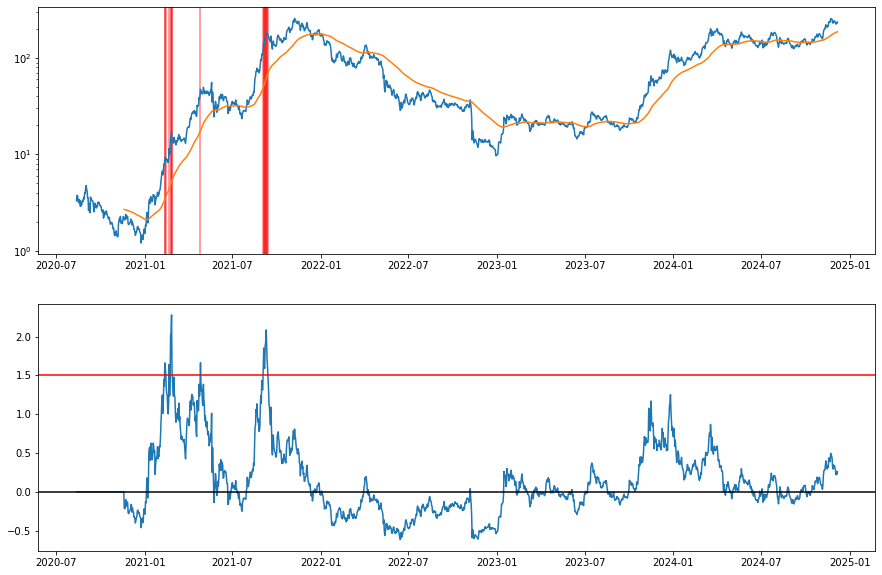

In [36]:
ma_len = 100
diff = (sol['close'] - sol.ta.ema(ma_len)) / sol.ta.ema(ma_len)
thr = diff.mean() + 3 * diff.std()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(sol[diff > thr].shape[0]):
    ax[0].axvline(sol[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(sol['close'])
ax[0].plot(sol.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
ax[1].axhline(thr, c='r')
ax[1].axhline(0, c='k')
plt.show()

# FET

In [37]:
fet = ds.get_data('FETUSDT', '1d', start_date='2020-1-1')

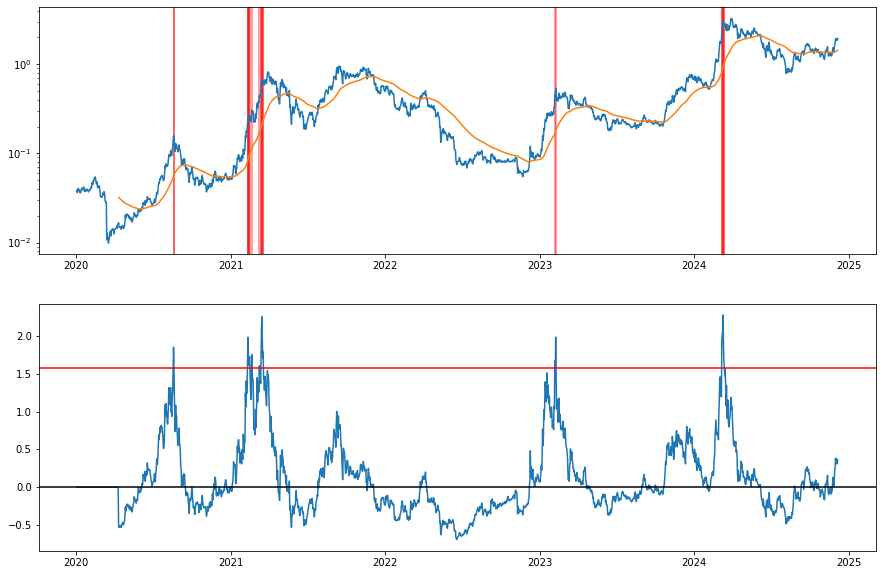

In [38]:
ma_len = 100
diff = (fet['close'] - fet.ta.ema(ma_len)) / fet.ta.ema(ma_len)
thr = diff.mean() + 3 * diff.std()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(fet[diff > thr].shape[0]):
    ax[0].axvline(fet[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(fet['close'])
ax[0].plot(fet.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
ax[1].axhline(thr, c='r')
ax[1].axhline(0, c='k')
plt.show()

# DOGE

In [39]:
doge = ds.get_data('DOGEUSDT', '1d', start_date='2020-1-1')

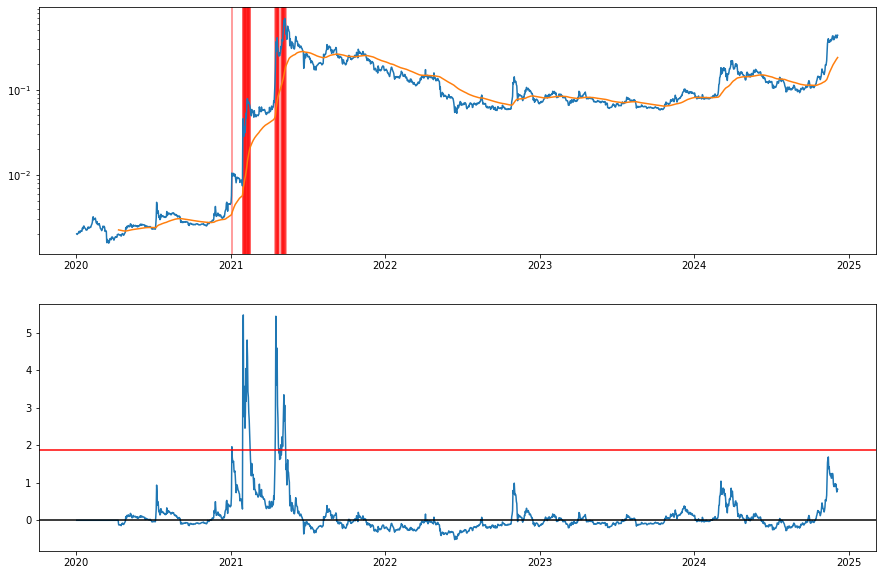

In [40]:
ma_len = 100
diff = (doge['close'] - doge.ta.ema(ma_len)) / doge.ta.ema(ma_len)
thr = diff.mean() + 3 * diff.std()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(doge[diff > thr].shape[0]):
    ax[0].axvline(doge[diff > thr].index[i], c='r', alpha=0.5)
ax[0].plot(doge['close'])
ax[0].plot(doge.ta.ema(ma_len))
ax[0].set_yscale('log')
ax[1].plot(diff.fillna(0))
ax[1].axhline(thr, c='r')
ax[1].axhline(0, c='k')
plt.show()